# Characterizing the impact with different fractions of DEGs used during subsampling in deDANSy

Here, we provide how changing the fraction of DEGs used during deDANSy impact the network separation values used in generating the separation score from deDANSy. As shown in other notebooks, the number of genes for each comparison impacts how robust the network separation values are. Here, we show how we conclude that 70% of the DEGs can be used as a general cutoff across most datasets.

In [1]:

import random
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import scikit_posthocs as sp

from tqdm import tqdm
from pybiomart import Dataset

import generateCompleteProteome
import ngramNets

from enrichment_helpers import *


In [2]:
# For reproducibility
random.seed(882)

In [3]:
# Creating some default parameters for future plots.
plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.01


In [4]:
# Importing the entire proteome
complete_ref,_ = generateCompleteProteome.import_proteome_files()

# Network drawing aesthetic parameters which will be used for consistency across network graphs.
net_draw_params = {'node_size':1, 'edgecolors':'k',
        'edge_color':'#808080', 'width':0.1, 'linewidths':0.2}

In [5]:
# pybiomart database for gene name conversions
dataset = Dataset(host = 'http://useast.ensembl.org', name='hsapiens_gene_ensembl',)
gene_ID_conv = dataset.query(attributes=['ensembl_gene_id','external_gene_name','external_synonym','uniprotswissprot'])

## Defining deDANSy objects that will be used for testing.

Here, we are using three datasets to show the considerations used when developing deDANSy. These include the HAS overexpression, the adipocyte culturing methods, and SOX10-deficiency datasets.

In [6]:
hasOE_dataset = pd.read_csv('DEG_data/MCF10_HAS_overexpression.csv')
hasOE_deg = ngramNets.DEdansy(hasOE_dataset, gene_ID_conv, data_ids=['ensembl_gene_id','external_gene_name'], uniprot_ref=complete_ref, dbl_check=True)

The following parameters were ignored:['dbl_check']
Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Building the reference network information.


In [7]:
# integrating the adipocyte dataset as well to show how well that translates too
# Expanding the list of changes to include the adipocyte dataset
adipocyte_df = pd.read_csv('DEG_data/Adipocyte_Culture_Methods_DEG_Results.csv')
adipo_nets = ngramNets.DEdansy(adipocyte_df, gene_ID_conv,uniprot_ref=complete_ref, data_ids='gene_id')
adipo_conds = ['Float_v_Diff','Float_v_TW','Float_v_Explant','Float_v_Fresh','Float_v_Packed','Packed_v_Diff','Explant_v_Whole','Diff_v_Undiff']

Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Building the reference network information.


In [8]:
sox10_dataset = pd.read_csv('DEG_data/SOX10_Invasion_DEG_Results.csv')
sox10_nets = ngramNets.DEdansy(sox10_dataset, gene_ID_conv,uniprot_ref=complete_ref, data_ids='ensembl_gene_id')
sox10_conds = ['4-11_v_A375','2-18_v_A375','4-11_v_2-18','CRT34_v_A375', 'CRT35_v_A375','CRT35_v_CRT34','CRT34_v_CRT34drug','CRT35_v_CRT35drug','CRT34_v_2-18', 'CRT34_v_4-11','CRT35_v_2-18', 'CRT35_v_4-11']

Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Building the reference network information.


## Detailed breakdown of the general process in assessing the cutoff using the CRT34 vs. gSOX10 #4 comparison of the SOX10-deficiency dataset.

Here, we replicate the code that is used for generating the distribution of network separation (and IQR) values. The only difference between this code and the code used in deDANSy is this only permits a single process for calculations and is not using function calls specifically. The functions that individual parts correspond to are provided.

In [9]:
# Defining a few key values and objects for the analysis. Note
p_vals_sweep = np.logspace(0,-10, num=21)
cond = 'CRT34_v_4-11'
sox10_nets.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=0.001,fc_thres=2)
orig_up = sox10_nets.up_DEGs
orig_dn = sox10_nets.down_DEGs


deg_info = sox10_nets.retrieve_protein_info(sox10_nets.up_DEGs+sox10_nets.down_DEGs)
arch_lens = deg_info['Interpro Domain Architecture IDs'].apply(lambda x: len(x.split('|')))
max_length = max([max(arch_lens),11])
deg_arch_dist = np.histogram(arch_lens, bins=range(max_length+1))
complete_arch_dist = sox10_nets.ref['Interpro Domain Architecture IDs'].apply(lambda x: len(x.split('|')))
weight_list = deg_arch_dist[0][0:11]
weight_list = np.append(weight_list,np.sum(deg_arch_dist[0][11:]))

# To ensure no changes are made to the existing reference dataframe.
ref_df_copy = sox10_nets.ref.copy()
up_frac = len(sox10_nets.up_DEGs)/len(deg_info) 

# Now going through the different fractions
frac_ns_data = []
for f in [0.5,0.6,0.7,0.8,0.9]:

    weight_list_n = np.round(weight_list/sum(weight_list)*(sum(weight_list)*f))

    rand_full_ns = []
    actual_full_ns = []
    subsample_ns_dists = []
    rand_ns_dists = []
    rand_iqr = []
    subsample_iqr = []

    # Only performing 30 trails to show the behavior and to save time
    for j in tqdm(range(30), desc=f'Random and subsampled networks for fraction {f}'):
        
        #### This is for the random networks which is found in the get_random_net_sep_metrics function
        rcd = get_random_count_dist(weight_list_n)
        rii = get_random_id_indices(complete_arch_dist,rcd)
        r_prots = designate_rand_DEGs(rii, ref_df_copy,up_frac)
        sox10_nets.set_DEG_ngrams(r_prots['Up'],r_prots['Down'], verbose=False)
        ns = sox10_nets.DEG_network_sep()
        rand_full_ns.append(ns)
        ns_vals = hypergeom_prune_ns(sox10_nets, p_vals_sweep)
        rand_ns_dists.append(ns_vals)
        rand_iqr.append(stats.iqr(ns_vals, nan_policy='omit'))


        #### This is for the subsampled networks (the get_subsample_net_sep_metrics)
        # Getting a random sample of the up DEGs
        rand_up = random.sample(orig_up, k=len(r_prots['Up']))
        rand_dn = random.sample(orig_dn, k=len(r_prots['Down']))
        sox10_nets.set_DEG_ngrams(rand_up,rand_dn, verbose=False)
        ns = sox10_nets.DEG_network_sep()
        actual_full_ns.append(ns)
        ns_vals = hypergeom_prune_ns(sox10_nets,p_vals_sweep)
        subsample_ns_dists.append(ns_vals)
        subsample_iqr.append(stats.iqr(ns_vals, nan_policy='omit'))

    # Putting the results into the dict
    frac_ns_data.append((f, rand_full_ns, actual_full_ns,rand_ns_dists, subsample_ns_dists,rand_iqr, subsample_iqr))

Random and subsampled networks for fraction 0.9: 100%|██████████| 30/30 [01:34<00:00,  3.15s/it]


In [10]:
# Now retrieving all the values to allow for plotting.

tst = pd.DataFrame().from_records(frac_ns_data, columns=['Fraction', 'Random NS','Subsample NS','Random Sweep Dist', 'Subsample Sweep Dist', 'Random IQR', 'Subsample IQR'])
tst.index = tst['Fraction']
tst = tst.melt(ignore_index=False)

In [11]:
# Focusing only on the network separation results during the sweep to show general characteristics that are being captured in the overall process.
tst2 = tst.copy()
tst2 = tst2[tst2['variable'].isin(['Subsample Sweep Dist','Random Sweep Dist'])].explode('value').explode('value')
tst2['p'] = p_vals_sweep.tolist()*int(len(tst2)/len(p_vals_sweep))
tst2['p']= -np.log10(tst2['p'])
tst2['Type'] = tst2['variable'].str.split(' ').str[0]
tst2.reset_index(inplace=True)

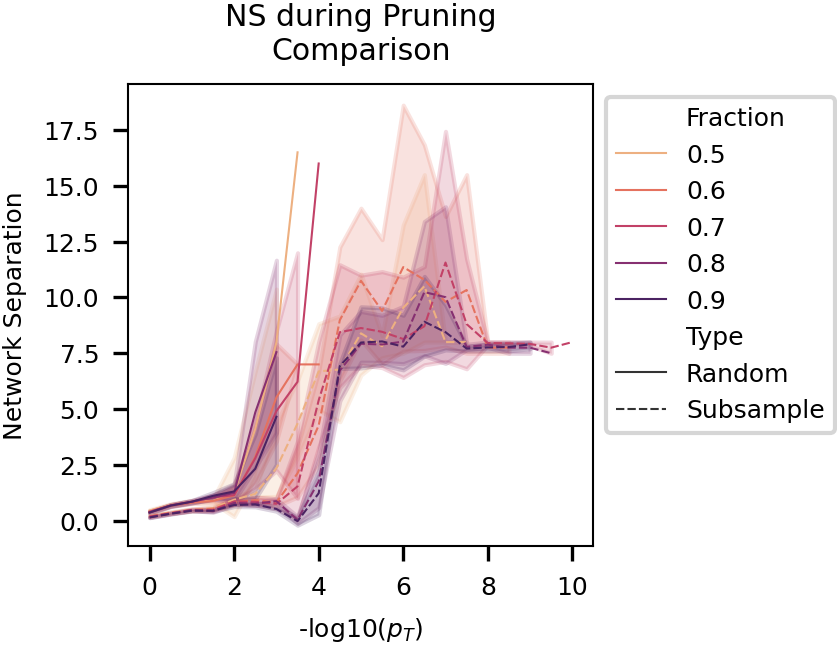

In [12]:
# Plotting the sweep
plt.figure(figsize=(2,2), dpi=300)
sns.lineplot(tst2, x = 'p', y ='value', hue='Fraction',style='Type',palette=sns.color_palette('flare',as_cmap=True),lw=0.5)
plt.ylabel('Network Separation')
plt.xlabel('-log10($p_{T}$)')
plt.legend(bbox_to_anchor=(1,1))
plt.title('NS during Pruning\nComparison')
plt.show()

In [13]:
# As part of the analysis showing how the statistical significance changes (or not)
tst4 = tst[tst['variable'].isin(['Random NS', 'Subsample NS'])]
tst4.reset_index(inplace=True)
stat_res = pd.DataFrame(columns=['test_stat','p'], index = [0.5,0.6,0.7,0.8,0.9],dtype=float)

print(f'For the comparison {cond} the fraction pairwise comparisons statistical tests were:')
for f in [0.5,0.6,0.7,0.8,0.9]:
    a = tst4[(tst4['Fraction'] == f) & (tst4['variable'] == 'Random NS')]['value'].tolist()[0]
    b = tst4[(tst4['Fraction'] == f) & (tst4['variable'] == 'Subsample NS')]['value'].tolist()[0]
    s, p = stats.mannwhitneyu(a,b, nan_policy='omit')
    stat_res.loc[f] = s,p
print(stat_res)


For the comparison CRT34_v_4-11 the fraction pairwise comparisons statistical tests were:
     test_stat             p
0.5      867.0  7.380286e-10
0.6      878.0  2.609853e-10
0.7      891.0  7.389083e-11
0.8      900.0  3.019859e-11
0.9      896.0  4.504322e-11


In [14]:
# Adding in the box plots to show how different the range of values are for each of the fractions
tst5 = tst4.copy()
tst5['Type'] = tst4['variable'].str.split(' ').str[0]
tst5 = tst5.explode('value')

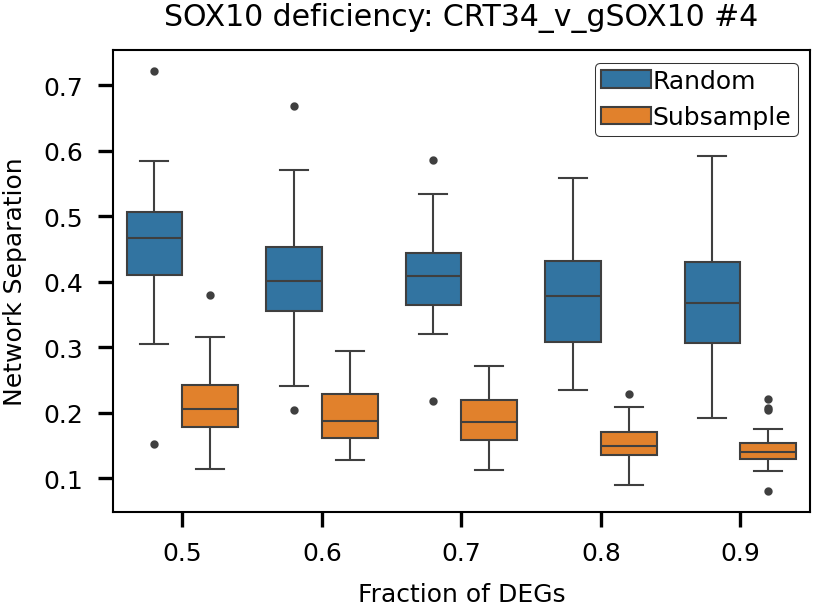

In [15]:
plt.figure(figsize=(3,2), dpi=300)
sns.boxplot(tst5, x='Fraction', y = 'value', hue='Type',linewidth=.5,fliersize=1)
plt.ylabel('Network Separation')
plt.xlabel('Fraction of DEGs')
l = plt.legend(edgecolor = 'k',handletextpad=0.05, borderpad=0.25)
l.get_frame().set_linewidth(0.25)
plt.title('SOX10 deficiency: CRT34_v_gSOX10 #4')
#plt.savefig('Figures/Manuscript Figures/Supplementary Figure deDANSy NS Variation/SOX10_DEG_Fraction_Sweep.svg')
plt.show()

From the above plot we can see at 70% is when the network separation values begin to increase relatively more compared to the 70-90% steps. However, this impact as shown with the stats does not alter the significance much.

## Repeating with other comparisons for each dataset

To see if this is a dataset-specific behavior or not we will check two other datasets and another comparison for general trends.

Will be overwriting existing DEG data.


Random and subsampled networks for fraction 0.9: 100%|██████████| 30/30 [01:42<00:00,  3.43s/it]

Fraction Sweep NS stat results
[(np.float64(525.0), np.float64(0.2707053377245183)), (np.float64(531.0), np.float64(0.2339889162810581)), (np.float64(600.0), np.float64(0.02708631838829594)), (np.float64(623.0), np.float64(0.010762612595411518)), (np.float64(759.0), np.float64(5.0911734853633686e-06))]


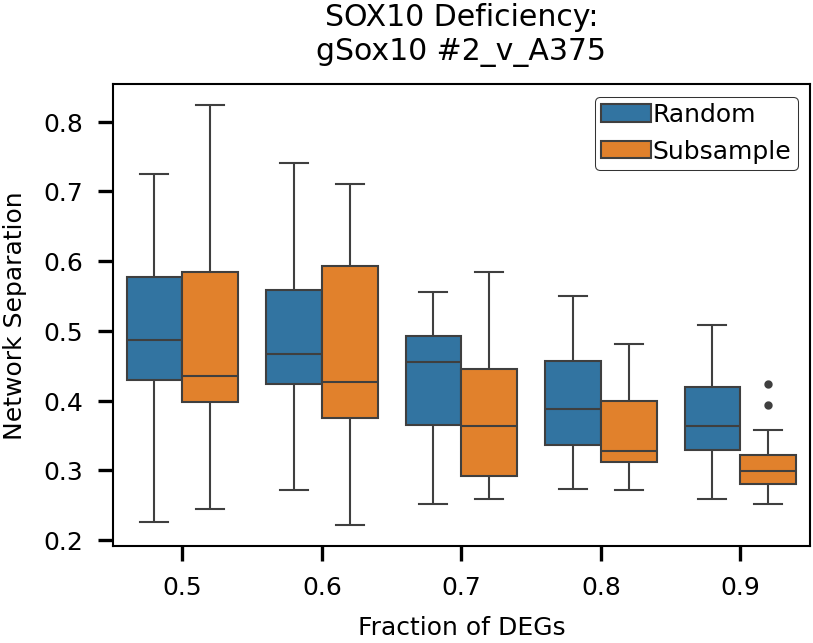

In [16]:
cond = '2-18_v_A375'
sox10_nets.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=0.001, fc_thres=2)
orig_up = sox10_nets.up_DEGs
orig_dn = sox10_nets.down_DEGs
deg_info = sox10_nets.retrieve_protein_info(sox10_nets.up_DEGs+sox10_nets.down_DEGs)
arch_lens = deg_info['Interpro Domain Architecture IDs'].apply(lambda x: len(x.split('|')))
deg_arch_dist = np.histogram(arch_lens, bins=range(max(arch_lens)+1))
complete_arch_dist = sox10_nets.ref['Interpro Domain Architecture IDs'].apply(lambda x: len(x.split('|')))
weight_list = deg_arch_dist[0][0:11]
weight_list = np.append(weight_list,np.sum(deg_arch_dist[0][11:]))
ref_df_copy = sox10_nets.ref.copy()
up_frac = len(sox10_nets.up_DEGs)/len(deg_info)
# Now normalizing the list 70% of the total number of DEGs available (depends on relative fractions. Don't want to bother making this completely correct)
frac_ns_data = []
for f in [0.5,0.6,0.7,0.8,0.9]:

    weight_list_n = np.round(weight_list/sum(weight_list)*(sum(weight_list)*f))

    #rand_ngram_pvals = {}
    rand_full_ns = []
    actual_full_ns = []
    subsample_ns_dists = []
    rand_ns_dists = []
    rand_iqr = []
    subsample_iqr = []
    for j in tqdm(range(30), desc=f'Random and subsampled networks for fraction {f}'):
        
        #### This is for the random networks
        rcd = get_random_count_dist(weight_list_n)
        rii = get_random_id_indices(complete_arch_dist,rcd)
        r_prots = designate_rand_DEGs(rii, ref_df_copy,up_frac)
        sox10_nets.set_DEG_ngrams(r_prots['Up'],r_prots['Down'], verbose=False)
        ns = sox10_nets.DEG_network_sep()
        rand_full_ns.append(ns)
        ns_vals = hypergeom_prune_ns(sox10_nets, p_vals_sweep)
        rand_ns_dists.append(ns_vals)
        rand_iqr.append(stats.iqr(ns_vals, nan_policy='omit'))


        #### This is for the subsampled networks
        # Getting a random sample of the up DEGs (not accounting for the n-gram length)
        rand_up = random.sample(orig_up, k=len(r_prots['Up']))
        rand_dn = random.sample(orig_dn, k=len(r_prots['Down']))
        sox10_nets.set_DEG_ngrams(rand_up,rand_dn, verbose=False)
        ns = sox10_nets.DEG_network_sep()
        actual_full_ns.append(ns)
        ns_vals = hypergeom_prune_ns(sox10_nets,p_vals_sweep)
        subsample_ns_dists.append(ns_vals)
        subsample_iqr.append(stats.iqr(ns_vals, nan_policy='omit'))

    # Putting the results into the dict
    frac_ns_data.append((f, rand_full_ns, actual_full_ns,rand_ns_dists, subsample_ns_dists,rand_iqr, subsample_iqr))
tst = pd.DataFrame().from_records(frac_ns_data, columns=['Fraction', 'Random NS','Subsample NS','Random Sweep Dist', 'Subsample Sweep Dist', 'Random IQR', 'Subsample IQR'])
tst.index = tst['Fraction']
tst = tst.melt(ignore_index=False)

tst4 = tst[tst['variable'].isin(['Random NS', 'Subsample NS'])]
tst4.reset_index(inplace=True)
stat_res = []
for f in [0.5,0.6,0.7,0.8,0.9]:
    a = tst4[(tst4['Fraction'] == f) & (tst4['variable'] == 'Random NS')]['value'].tolist()[0]
    b = tst4[(tst4['Fraction'] == f) & (tst4['variable'] == 'Subsample NS')]['value'].tolist()[0]
    s, p = stats.mannwhitneyu(a,b, nan_policy='omit')
    stat_res.append((s,p))
print('Fraction Sweep NS stat results')
print(stat_res)
# Adding in the box plots to show how different the range of values are for each of the fractions
tst5 = tst4.copy()
tst5['Type'] = tst4['variable'].str.split(' ').str[0]
tst5 = tst5.explode('value')
plt.figure(figsize=(3,2), dpi = 300)
sns.boxplot(tst5, x='Fraction', y = 'value', hue='Type',linewidth=0.5, fliersize=1)
plt.ylabel('Network Separation')
plt.xlabel('Fraction of DEGs')
l = plt.legend(edgecolor = 'k',handletextpad=0.05, borderpad=0.25)
l.get_frame().set_linewidth(0.25)
plt.title('SOX10 Deficiency:\ngSox10 #2_v_A375')
#plt.savefig('Figures/Manuscript Figures/Supplementary Figure deDANSy NS Variation/Sox10_Comp2_DEG_Fraction_Sweep.svg')
plt.show()


Random and subsampled networks for fraction 0.9: 100%|██████████| 30/30 [00:25<00:00,  1.17it/s]

Fraction Sweep NS stat results
[(np.float64(431.0), np.float64(0.7844597689495465)), (np.float64(464.0), np.float64(0.8418014501581275)), (np.float64(587.0), np.float64(0.04358354777581831)), (np.float64(622.0), np.float64(0.01122776446668884)), (np.float64(594.0), np.float64(0.033874280129520255))]


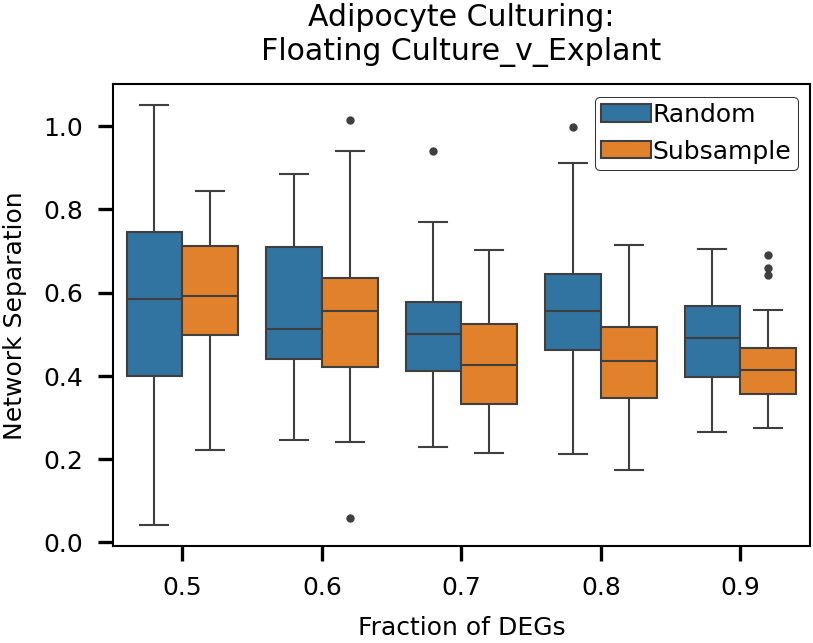

In [17]:
cond = 'Float_v_Explant'
adipo_nets.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=0.0001, fc_thres=3)
orig_up = adipo_nets.up_DEGs
orig_dn = adipo_nets.down_DEGs
deg_info = adipo_nets.retrieve_protein_info(adipo_nets.up_DEGs+adipo_nets.down_DEGs)
arch_lens = deg_info['Interpro Domain Architecture IDs'].apply(lambda x: len(x.split('|')))
deg_arch_dist = np.histogram(arch_lens, bins=range(max(arch_lens)+1))
complete_arch_dist = adipo_nets.ref['Interpro Domain Architecture IDs'].apply(lambda x: len(x.split('|')))
weight_list = deg_arch_dist[0][0:11]
weight_list = np.append(weight_list,np.sum(deg_arch_dist[0][11:]))
ref_df_copy = adipo_nets.ref.copy()
up_frac = len(adipo_nets.up_DEGs)/len(deg_info)
# Now normalizing the list 70% of the total number of DEGs available (depends on relative fractions. Don't want to bother making this completely correct)
frac_ns_data = []
for f in [0.5,0.6,0.7,0.8,0.9]:

    weight_list_n = np.round(weight_list/sum(weight_list)*(sum(weight_list)*f))

    #rand_ngram_pvals = {}
    rand_full_ns = []
    actual_full_ns = []
    subsample_ns_dists = []
    rand_ns_dists = []
    rand_iqr = []
    subsample_iqr = []
    for j in tqdm(range(30), desc=f'Random and subsampled networks for fraction {f}'):
        
        #### This is for the random networks
        rcd = get_random_count_dist(weight_list_n)
        rii = get_random_id_indices(complete_arch_dist,rcd)
        r_prots = designate_rand_DEGs(rii, ref_df_copy,up_frac)
        adipo_nets.set_DEG_ngrams(r_prots['Up'],r_prots['Down'], verbose=False)
        ns = adipo_nets.DEG_network_sep()
        rand_full_ns.append(ns)
        ns_vals = hypergeom_prune_ns(adipo_nets, p_vals_sweep)
        rand_ns_dists.append(ns_vals)
        rand_iqr.append(stats.iqr(ns_vals, nan_policy='omit'))


        #### This is for the subsampled networks
        # Getting a random sample of the up DEGs (not accounting for the n-gram length)
        rand_up = random.sample(orig_up, k=len(r_prots['Up']))
        rand_dn = random.sample(orig_dn, k=len(r_prots['Down']))
        adipo_nets.set_DEG_ngrams(rand_up,rand_dn, verbose=False)
        ns = adipo_nets.DEG_network_sep()
        actual_full_ns.append(ns)
        ns_vals = hypergeom_prune_ns(adipo_nets,p_vals_sweep)
        subsample_ns_dists.append(ns_vals)
        subsample_iqr.append(stats.iqr(ns_vals, nan_policy='omit'))

    # Putting the results into the dict
    frac_ns_data.append((f, rand_full_ns, actual_full_ns,rand_ns_dists, subsample_ns_dists,rand_iqr, subsample_iqr))
tst = pd.DataFrame().from_records(frac_ns_data, columns=['Fraction', 'Random NS','Subsample NS','Random Sweep Dist', 'Subsample Sweep Dist', 'Random IQR', 'Subsample IQR'])
tst.index = tst['Fraction']
tst = tst.melt(ignore_index=False)
tst4 = tst[tst['variable'].isin(['Random NS', 'Subsample NS'])]
tst4.reset_index(inplace=True)
stat_res = []
for f in [0.5,0.6,0.7,0.8,0.9]:
    a = tst4[(tst4['Fraction'] == f) & (tst4['variable'] == 'Random NS')]['value'].tolist()[0]
    b = tst4[(tst4['Fraction'] == f) & (tst4['variable'] == 'Subsample NS')]['value'].tolist()[0]
    s, p = stats.mannwhitneyu(a,b, nan_policy='omit')
    stat_res.append((s,p))
print('Fraction Sweep NS stat results')
print(stat_res)
# Adding in the box plots to show how different the range of values are for each of the fractions
tst5 = tst4.copy()
tst5['Type'] = tst4['variable'].str.split(' ').str[0]
tst5 = tst5.explode('value')
plt.figure(figsize=(3,2), dpi = 300)
sns.boxplot(tst5, x='Fraction', y = 'value', hue='Type',linewidth=0.5, fliersize=1)
plt.ylabel('Network Separation')
plt.xlabel('Fraction of DEGs')
l = plt.legend(edgecolor = 'k',handletextpad=0.05, borderpad=0.25)
l.get_frame().set_linewidth(0.25)
plt.title('Adipocyte Culturing:\nFloating Culture_v_Explant')
#plt.savefig('Figures/Manuscript Figures/Supplementary Figure deDANSy NS Variation/Adipocyte_Comp1_DEG_Fraction_Sweep.svg')
plt.show()


Will be overwriting existing DEG data.


Random and subsampled networks for fraction 0.9: 100%|██████████| 30/30 [01:09<00:00,  2.32s/it]

Fraction Sweep NS stat results
[(np.float64(790.0), np.float64(5.185675139382171e-07)), (np.float64(864.0), np.float64(9.755501134576291e-10)), (np.float64(860.0), np.float64(1.4109773081080241e-09)), (np.float64(895.0), np.float64(4.9751664405934065e-11)), (np.float64(895.0), np.float64(4.9751664405934065e-11))]


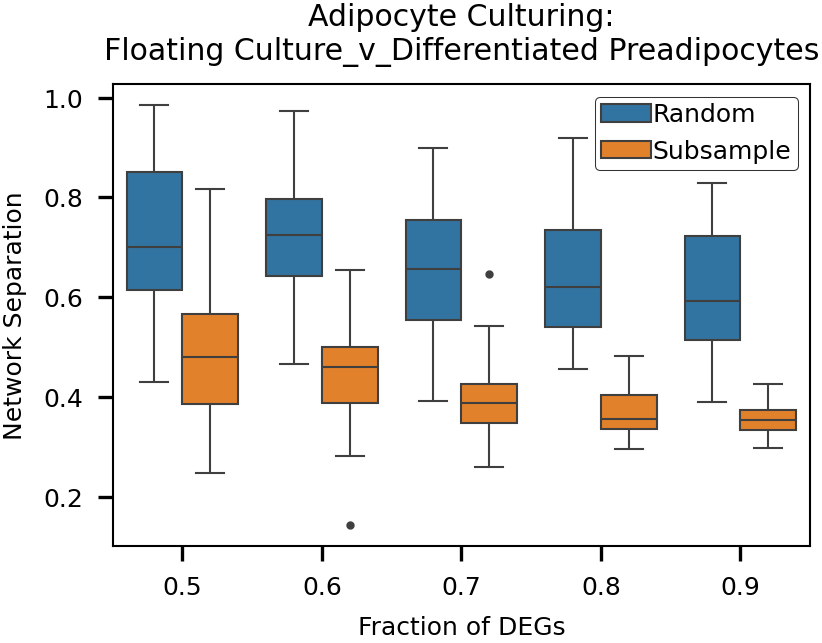

In [18]:
cond = 'Float_v_Diff'
adipo_nets.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=0.0001, fc_thres=3)
orig_up = adipo_nets.up_DEGs
orig_dn = adipo_nets.down_DEGs
deg_info = adipo_nets.retrieve_protein_info(adipo_nets.up_DEGs+adipo_nets.down_DEGs)
arch_lens = deg_info['Interpro Domain Architecture IDs'].apply(lambda x: len(x.split('|')))
deg_arch_dist = np.histogram(arch_lens, bins=range(max(arch_lens)+1))
complete_arch_dist = adipo_nets.ref['Interpro Domain Architecture IDs'].apply(lambda x: len(x.split('|')))
weight_list = deg_arch_dist[0][0:11]
weight_list = np.append(weight_list,np.sum(deg_arch_dist[0][11:]))
ref_df_copy = adipo_nets.ref.copy()
up_frac = len(adipo_nets.up_DEGs)/len(deg_info)
# Now normalizing the list 70% of the total number of DEGs available (depends on relative fractions. Don't want to bother making this completely correct)
frac_ns_data = []
for f in [0.5,0.6,0.7,0.8,0.9]:

    weight_list_n = np.round(weight_list/sum(weight_list)*(sum(weight_list)*f))

    #rand_ngram_pvals = {}
    rand_full_ns = []
    actual_full_ns = []
    subsample_ns_dists = []
    rand_ns_dists = []
    rand_iqr = []
    subsample_iqr = []
    for j in tqdm(range(30), desc=f'Random and subsampled networks for fraction {f}'):
        
        #### This is for the random networks
        rcd = get_random_count_dist(weight_list_n)
        rii = get_random_id_indices(complete_arch_dist,rcd)
        r_prots = designate_rand_DEGs(rii, ref_df_copy,up_frac)
        adipo_nets.set_DEG_ngrams(r_prots['Up'],r_prots['Down'], verbose=False)
        ns = adipo_nets.DEG_network_sep()
        rand_full_ns.append(ns)
        ns_vals = hypergeom_prune_ns(adipo_nets, p_vals_sweep)
        rand_ns_dists.append(ns_vals)
        rand_iqr.append(stats.iqr(ns_vals, nan_policy='omit'))


        #### This is for the subsampled networks
        # Getting a random sample of the up DEGs (not accounting for the n-gram length)
        rand_up = random.sample(orig_up, k=len(r_prots['Up']))
        rand_dn = random.sample(orig_dn, k=len(r_prots['Down']))
        adipo_nets.set_DEG_ngrams(rand_up,rand_dn, verbose=False)
        ns = adipo_nets.DEG_network_sep()
        actual_full_ns.append(ns)
        ns_vals = hypergeom_prune_ns(adipo_nets,p_vals_sweep)
        subsample_ns_dists.append(ns_vals)
        subsample_iqr.append(stats.iqr(ns_vals, nan_policy='omit'))

    # Putting the results into the dict
    frac_ns_data.append((f, rand_full_ns, actual_full_ns,rand_ns_dists, subsample_ns_dists,rand_iqr, subsample_iqr))
tst = pd.DataFrame().from_records(frac_ns_data, columns=['Fraction', 'Random NS','Subsample NS','Random Sweep Dist', 'Subsample Sweep Dist', 'Random IQR', 'Subsample IQR'])
tst.index = tst['Fraction']
tst = tst.melt(ignore_index=False)
tst4 = tst[tst['variable'].isin(['Random NS', 'Subsample NS'])]
tst4.reset_index(inplace=True)
stat_res = []
for f in [0.5,0.6,0.7,0.8,0.9]:
    a = tst4[(tst4['Fraction'] == f) & (tst4['variable'] == 'Random NS')]['value'].tolist()[0]
    b = tst4[(tst4['Fraction'] == f) & (tst4['variable'] == 'Subsample NS')]['value'].tolist()[0]
    s, p = stats.mannwhitneyu(a,b, nan_policy='omit')
    stat_res.append((s,p))
print('Fraction Sweep NS stat results')
print(stat_res)
# Adding in the box plots to show how different the range of values are for each of the fractions
tst5 = tst4.copy()
tst5['Type'] = tst4['variable'].str.split(' ').str[0]
tst5 = tst5.explode('value')
plt.figure(figsize = (3,2), dpi =300)
sns.boxplot(tst5, x='Fraction', y = 'value', hue='Type', linewidth=0.5, fliersize = 1)
plt.xlabel('Fraction of DEGs')
plt.ylabel('Network Separation')
l = plt.legend(edgecolor = 'k',handletextpad=0.05, borderpad=0.25)
l.get_frame().set_linewidth(0.25)
plt.title('Adipocyte Culturing:\nFloating Culture_v_Differentiated Preadipocytes')
#plt.savefig('Figures/Manuscript Figures/Supplementary Figure deDANSy NS Variation/Adipo_Comp2_DEG_Fraction_Sweep.svg')
plt.show()


Random and subsampled networks for fraction 0.9: 100%|██████████| 30/30 [00:19<00:00,  1.57it/s]

Fraction Sweep NS stat results
[(np.float64(665.0), np.float64(0.0015177961906131159)), (np.float64(566.0), np.float64(0.08771037748098136)), (np.float64(542.0), np.float64(0.17612754548398757)), (np.float64(560.0), np.float64(0.10546994652177778)), (np.float64(563.0), np.float64(0.09626283103615173))]


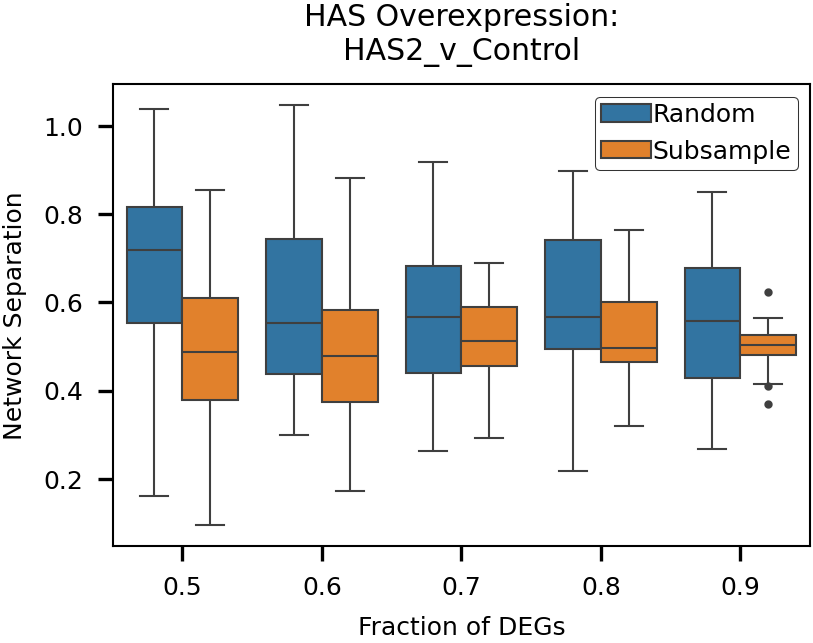

In [19]:
# Now the final one which is one of the conditions that tends to be on the border
cond = 'HAS2'
hasOE_deg.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=0.05)
orig_up = hasOE_deg.up_DEGs
orig_dn = hasOE_deg.down_DEGs
deg_info = hasOE_deg.retrieve_protein_info(hasOE_deg.up_DEGs+hasOE_deg.down_DEGs)
arch_lens = deg_info['Interpro Domain Architecture IDs'].apply(lambda x: len(x.split('|')))
deg_arch_dist = np.histogram(arch_lens, bins=range(max(arch_lens)+1))
complete_arch_dist = hasOE_deg.ref['Interpro Domain Architecture IDs'].apply(lambda x: len(x.split('|')))
weight_list = deg_arch_dist[0][0:11]
weight_list = np.append(weight_list,np.sum(deg_arch_dist[0][11:]))
ref_df_copy = hasOE_deg.ref.copy()
up_frac = len(hasOE_deg.up_DEGs)/len(deg_info)
# Now normalizing the list 70% of the total number of DEGs available (depends on relative fractions. Don't want to bother making this completely correct)
frac_ns_data = []
for f in [0.5,0.6,0.7,0.8,0.9]:

    weight_list_n = np.round(weight_list/sum(weight_list)*(sum(weight_list)*f))

    #rand_ngram_pvals = {}
    rand_full_ns = []
    actual_full_ns = []
    subsample_ns_dists = []
    rand_ns_dists = []
    rand_iqr = []
    subsample_iqr = []
    for j in tqdm(range(30), desc=f'Random and subsampled networks for fraction {f}'):
        
        #### This is for the random networks
        rcd = get_random_count_dist(weight_list_n)
        rii = get_random_id_indices(complete_arch_dist,rcd)
        r_prots = designate_rand_DEGs(rii, ref_df_copy,up_frac)
        hasOE_deg.set_DEG_ngrams(r_prots['Up'],r_prots['Down'], verbose=False)
        ns = hasOE_deg.DEG_network_sep()
        rand_full_ns.append(ns)
        ns_vals = hypergeom_prune_ns(hasOE_deg, p_vals_sweep)
        rand_ns_dists.append(ns_vals)
        rand_iqr.append(stats.iqr(ns_vals, nan_policy='omit'))


        #### This is for the subsampled networks
        # Getting a random sample of the up DEGs (not accounting for the n-gram length)
        rand_up = random.sample(orig_up, k=len(r_prots['Up']))
        rand_dn = random.sample(orig_dn, k=len(r_prots['Down']))
        hasOE_deg.set_DEG_ngrams(rand_up,rand_dn, verbose=False)
        ns = hasOE_deg.DEG_network_sep()
        actual_full_ns.append(ns)
        ns_vals = hypergeom_prune_ns(hasOE_deg,p_vals_sweep)
        subsample_ns_dists.append(ns_vals)
        subsample_iqr.append(stats.iqr(ns_vals, nan_policy='omit'))

    # Putting the results into the dict
    frac_ns_data.append((f, rand_full_ns, actual_full_ns,rand_ns_dists, subsample_ns_dists,rand_iqr, subsample_iqr))
tst = pd.DataFrame().from_records(frac_ns_data, columns=['Fraction', 'Random NS','Subsample NS','Random Sweep Dist', 'Subsample Sweep Dist', 'Random IQR', 'Subsample IQR'])
tst.index = tst['Fraction']
tst = tst.melt(ignore_index=False)

tst4 = tst[tst['variable'].isin(['Random NS', 'Subsample NS'])]
tst4.reset_index(inplace=True)
stat_res = []
for f in [0.5,0.6,0.7,0.8,0.9]:
    a = tst4[(tst4['Fraction'] == f) & (tst4['variable'] == 'Random NS')]['value'].tolist()[0]
    b = tst4[(tst4['Fraction'] == f) & (tst4['variable'] == 'Subsample NS')]['value'].tolist()[0]
    s, p = stats.mannwhitneyu(a,b, nan_policy='omit')
    stat_res.append((s,p))
print('Fraction Sweep NS stat results')
print(stat_res)
# Adding in the box plots to show how different the range of values are for each of the fractions
tst5 = tst4.copy()
tst5['Type'] = tst4['variable'].str.split(' ').str[0]
tst5 = tst5.explode('value')
plt.figure(figsize = (3,2), dpi=300)
sns.boxplot(tst5, x='Fraction', y = 'value', hue='Type', linewidth=0.5, fliersize = 1)
plt.ylabel('Network Separation')
plt.xlabel('Fraction of DEGs')
l = plt.legend(edgecolor = 'k',handletextpad=0.05, borderpad=0.25)
l.get_frame().set_linewidth(0.25)
plt.title('HAS Overexpression:\nHAS2_v_Control')
#plt.savefig('Figures/Manuscript Figures/Supplementary Figure deDANSy NS Variation/HAS_DEG_Fraction_Sweep.svg')
plt.show()

Will be overwriting existing DEG data.


Random and subsampled networks for fraction 0.9: 100%|██████████| 30/30 [00:46<00:00,  1.54s/it]

Fraction Sweep NS stat results
[(np.float64(890.0), np.float64(8.152744512218773e-11)), (np.float64(898.0), np.float64(3.689725853980989e-11)), (np.float64(899.0), np.float64(3.3383888204288e-11)), (np.float64(895.0), np.float64(4.9751664405934065e-11)), (np.float64(900.0), np.float64(3.0198593591621564e-11))]


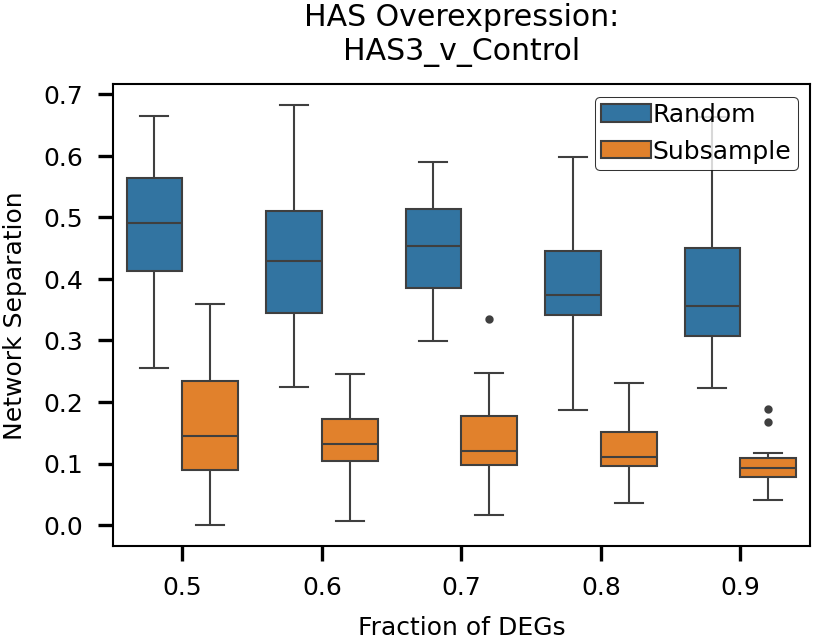

In [20]:
# Now the final one which is one of the conditions that tends to be on the border
cond = 'HAS3'
hasOE_deg.calc_DEG_ngrams(data_cols=['log2FoldChange_'+cond,'padj_'+cond],alpha=0.05)
orig_up = hasOE_deg.up_DEGs
orig_dn = hasOE_deg.down_DEGs
deg_info = hasOE_deg.retrieve_protein_info(hasOE_deg.up_DEGs+hasOE_deg.down_DEGs)
arch_lens = deg_info['Interpro Domain Architecture IDs'].apply(lambda x: len(x.split('|')))
deg_arch_dist = np.histogram(arch_lens, bins=range(max(arch_lens)+1))
complete_arch_dist = hasOE_deg.ref['Interpro Domain Architecture IDs'].apply(lambda x: len(x.split('|')))
weight_list = deg_arch_dist[0][0:11]
weight_list = np.append(weight_list,np.sum(deg_arch_dist[0][11:]))
ref_df_copy = hasOE_deg.ref.copy()
up_frac = len(hasOE_deg.up_DEGs)/len(deg_info)
# Now normalizing the list 70% of the total number of DEGs available (depends on relative fractions. Don't want to bother making this completely correct)
frac_ns_data = []
for f in [0.5,0.6,0.7,0.8,0.9]:

    weight_list_n = np.round(weight_list/sum(weight_list)*(sum(weight_list)*f))

    #rand_ngram_pvals = {}
    rand_full_ns = []
    actual_full_ns = []
    subsample_ns_dists = []
    rand_ns_dists = []
    rand_iqr = []
    subsample_iqr = []
    for j in tqdm(range(30), desc=f'Random and subsampled networks for fraction {f}'):
        
        #### This is for the random networks
        rcd = get_random_count_dist(weight_list_n)
        rii = get_random_id_indices(complete_arch_dist,rcd)
        r_prots = designate_rand_DEGs(rii, ref_df_copy,up_frac)
        hasOE_deg.set_DEG_ngrams(r_prots['Up'],r_prots['Down'], verbose=False)
        ns = hasOE_deg.DEG_network_sep()
        rand_full_ns.append(ns)
        ns_vals = hypergeom_prune_ns(hasOE_deg, p_vals_sweep)
        rand_ns_dists.append(ns_vals)
        rand_iqr.append(stats.iqr(ns_vals, nan_policy='omit'))


        #### This is for the subsampled networks
        # Getting a random sample of the up DEGs (not accounting for the n-gram length)
        rand_up = random.sample(orig_up, k=len(r_prots['Up']))
        rand_dn = random.sample(orig_dn, k=len(r_prots['Down']))
        hasOE_deg.set_DEG_ngrams(rand_up,rand_dn, verbose=False)
        ns = hasOE_deg.DEG_network_sep()
        actual_full_ns.append(ns)
        ns_vals = hypergeom_prune_ns(hasOE_deg,p_vals_sweep)
        subsample_ns_dists.append(ns_vals)
        subsample_iqr.append(stats.iqr(ns_vals, nan_policy='omit'))

    # Putting the results into the dict
    frac_ns_data.append((f, rand_full_ns, actual_full_ns,rand_ns_dists, subsample_ns_dists,rand_iqr, subsample_iqr))
tst = pd.DataFrame().from_records(frac_ns_data, columns=['Fraction', 'Random NS','Subsample NS','Random Sweep Dist', 'Subsample Sweep Dist', 'Random IQR', 'Subsample IQR'])
tst.index = tst['Fraction']
tst = tst.melt(ignore_index=False)

tst4 = tst[tst['variable'].isin(['Random NS', 'Subsample NS'])]
tst4.reset_index(inplace=True)
stat_res = []
for f in [0.5,0.6,0.7,0.8,0.9]:
    a = tst4[(tst4['Fraction'] == f) & (tst4['variable'] == 'Random NS')]['value'].tolist()[0]
    b = tst4[(tst4['Fraction'] == f) & (tst4['variable'] == 'Subsample NS')]['value'].tolist()[0]
    s, p = stats.mannwhitneyu(a,b, nan_policy='omit')
    stat_res.append((s,p))
print('Fraction Sweep NS stat results')
print(stat_res)
# Adding in the box plots to show how different the range of values are for each of the fractions
tst5 = tst4.copy()
tst5['Type'] = tst4['variable'].str.split(' ').str[0]
tst5 = tst5.explode('value')
plt.figure(figsize = (3,2), dpi=300)
sns.boxplot(tst5, x='Fraction', y = 'value', hue='Type', linewidth=0.5, fliersize = 1)
plt.ylabel('Network Separation')
plt.xlabel('Fraction of DEGs')
l = plt.legend(edgecolor = 'k',handletextpad=0.05, borderpad=0.25)
l.get_frame().set_linewidth(0.25)
plt.title('HAS Overexpression:\nHAS3_v_Control')
#plt.savefig('Figures/Manuscript Figures/Supplementary Figure deDANSy NS Variation/HAS3_DEG_Fraction_Sweep.svg')
plt.show()

From the plots throughout this notebook, we can see that 70% is a transition point for many of the comparisons, if a change in network separation is observed. This suggests, that to ensure a robust measurement of how the subnetworks are separated at the very least 70% of the DEGs have to be used for subsampling. While certain comparisons may not require it (as seen above with the HAS3 overexpression), it is not generalizable. Therefore, for the purposes of deDANSy, we will default to 70% of DEGs being used for subsampling.